In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch

In [2]:
from rllib_emecom.utils.experiment_utils import initialise_ray
initialise_ray(include_dashboard=False)

pygame 2.3.0 (SDL 2.24.2, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


2023-11-07 07:10:27,800	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
2023-11-07 07:10:30,719	INFO worker.py:1649 -- Started a local Ray instance.


In [3]:
from IPython.display import clear_output
from ray.rllib.algorithms.algorithm import Algorithm

In [4]:
runs_dir = 'ray_results/goal_comms_gridworld/goal_comms_gridworld/'
run = 'PPOMACRL_goal_comms_gridworld_e7527_00000_0_2023-11-06_13-24-44'
ckpt = 'checkpoint_000089'
algo = Algorithm.from_checkpoint(f'{runs_dir}{run}/{ckpt}')
clear_output()
print('Loaded checkpoint.')

Loaded checkpoint.


In [5]:
eval_results = algo.evaluate()
eval_results.keys()

KeyboardInterrupt: 

In [ ]:
print('Episode Reward Mean:', eval_results['evaluation']['episode_reward_mean'])

Episode Reward Mean: -8.2


In [16]:
from rllib_emecom.utils.video_utils import embed_mp4
media = eval_results['evaluation']['sampler_results']['episode_media']
for k in media:
    if k.startswith('env'):
        video, *_ = media[k]
        break
embed_mp4(video._path)

In [ ]:
from typing import Optional, Dict, Union

from ray.rllib.core.models.base import SampleBatch
from ray.rllib.algorithms.callbacks import DefaultCallbacks, make_multi_callbacks
from ray.rllib.evaluation.episode import Episode
from ray.rllib.evaluation.episode_v2 import EpisodeV2
from ray.rllib.utils.typing import PolicyID
from ray.rllib import Policy, BaseEnv

from rllib_emecom.utils.video_callback import get_sub_env
from rllib_emecom.macrl.ppo.macrl_ppo_module import PPOTorchMACRLModule
from rllib_emecom.env.goal_comms_gridworld import parallel_env as GoalCommsGridworldEnv


class CollectCommsDataCallback(DefaultCallbacks):

    def __init__(self):
        super().__init__()
        self.data = []

    def get_env_state(self, goal_comms_env: GoalCommsGridworldEnv) -> dict:
        agent_ids = goal_comms_env.agents

        def get_known_goal_agent(agent):
            # agent knows the goal of agent_goal_map[agent]
            other_agent = goal_comms_env.agent_goal_map[agent]
            return agent_ids[other_agent.index]

        return {
            # key knows the goal of the value
            # so key is the sender and value is the receiver
            'goal_knowledge_map' : {
                agent: get_known_goal_agent(agent)
                for agent in agent_ids
            },
            'agent_positions': {
                agent: goal_comms_env.agents_map[agent].pose
                for agent in agent_ids
            },
            'goal_positions': {
                agent: goal_comms_env.agents_map[agent].goal
                for agent in agent_ids
            },
        }

    def on_episode_step(
        self,
        *,
        worker,
        base_env: BaseEnv,
        policies: Optional[Dict[PolicyID, Policy]] = None,
        episode: Union[Episode, EpisodeV2],
        env_index: Optional[int] = None,
        **kwargs,
    ) -> None:
        macrl_module = policies['default_policy'].model
        assert isinstance(macrl_module, PPOTorchMACRLModule)
        env = get_sub_env(base_env, env_index)
        goal_comms_env = env.env.unwrapped.par_env
        assert isinstance(goal_comms_env, GoalCommsGridworldEnv)

        last_action_logits = {   
            agent_id: action_batch[SampleBatch.ACTION_DIST_INPUTS][env_index].detach().cpu().numpy()
            for agent_id, action_batch in macrl_module.last_actor_outputs.items()
        }

        self.data.append({
            'comms': macrl_module.get_last_msgs(env_index),
            'total_env_steps': episode.total_env_steps,
            'total_reward': episode.total_reward,
            'episode_id': episode.episode_id,
            'env_index': env_index,
            'last_obs': macrl_module.last_inputs[SampleBatch.OBS][env_index],
            'last_action_logits': last_action_logits,
            'env_state': self.get_env_state(goal_comms_env),
        })

In [ ]:
from rllib_emecom.utils.video_callback import VideoEvaluationsCallback
from ray.rllib.evaluation.worker_set import WorkerSet

eval_config = algo.evaluation_config.copy(copy_frozen=False)
eval_config.callbacks_class = CollectCommsDataCallback

eval_worker_set = WorkerSet(
    env_creator=algo.env_creator,
    validate_env=None,
    default_policy_class=algo.get_default_policy_class(algo.config),
    config=eval_config,
    num_workers=0,
    logdir=algo.logdir,
)

worker = eval_worker_set.local_worker()

2023-11-07 04:37:16,652	WARNING algorithm_config.py:2574 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.


Building MACRL module...
Comms spec: {'message_dim': 3, 'comm_channels': {'agent_0': ['agent_1', 'agent_2'], 'agent_1': ['agent_0', 'agent_2'], 'agent_2': ['agent_0', 'agent_1']}, 'channel_fn': 'gumbel_softmax', 'channel_fn_config': {'temperature': 3.0, 'temperature_annealing': False, 'annealing_start_iter': 0, 'n_anneal_iterations': 500, 'final_temperature': 0.5, 'channel_noise': 0.25, 'channel_activation': 'tanh'}, 'n_agents': 3}
Communication channel function: <rllib_emecom.macrl.comms.gumbel_softmax.GumbelSoftmaxCommunicationChannel object at 0x7f8d28189f30>


In [ ]:
policy = worker.get_policy('default_policy')
module = policy.model
module.comm_channel_fn.set_force_eval(True)
module.comm_channel_fn, module.comm_channel_fn.temperature

(<rllib_emecom.macrl.comms.gumbel_softmax.GumbelSoftmaxCommunicationChannel at 0x7f8d28189f30>,
 3.0)

In [ ]:
algo.evaluation_workers = eval_worker_set
collect_comms_data_cb = worker.callbacks
collect_comms_data_cb.data.clear()

In [ ]:
collect_comms_data_cb.data

[]

In [ ]:
import tqdm

n_evals = 50

mean_reward = 0
mean_episode_length = 0

progbar = tqdm.tqdm(range(n_evals))

for i in range(n_evals):
    eval_results = algo.evaluate()

    mean_reward += eval_results['evaluation']['sampler_results']['episode_reward_mean']
    mean_episode_length += eval_results['evaluation']['sampler_results']['episode_len_mean']

    progbar.update()

progbar.close()

mean_reward /= n_evals
mean_episode_length /= n_evals

print(f'Mean reward: {mean_reward:.2f}, Mean episode length: {mean_episode_length:.2f}')

100%|██████████| 50/50 [00:44<00:00,  1.12it/s]

Mean reward: -8.996800000000002, Mean episode length: 7.025600000000001


In [ ]:
len(collect_comms_data_cb.data)

8782

In [ ]:
collect_comms_data_cb.data[0]

{'comms': {'agent_0': {'agent_1': array([0., 1., 0.], dtype=float32),
   'agent_2': array([0., 0., 1.], dtype=float32)},
  'agent_1': {'agent_0': array([0., 0., 1.], dtype=float32),
   'agent_2': array([1., 0., 0.], dtype=float32)},
  'agent_2': {'agent_0': array([1., 0., 0.], dtype=float32),
   'agent_1': array([1., 0., 0.], dtype=float32)}},
 'total_env_steps': 1,
 'total_reward': -3.0,
 'episode_id': 883471098334147705,
 'env_index': 0,
 'last_obs': tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0

In [ ]:
df = pd.DataFrame([
    {
        'receiver': recv_agent,
        'sender': send_agent,
        'goal_x': item['env_state']['goal_positions'][recv_agent][0],
        'goal_y': item['env_state']['goal_positions'][recv_agent][1],
        'pos_x': item['env_state']['agent_positions'][recv_agent][0],
        'pos_y': item['env_state']['agent_positions'][recv_agent][1],
        'sender_pos_x': item['env_state']['agent_positions'][send_agent][0],
        'sender_pos_y': item['env_state']['agent_positions'][send_agent][1],
        'receiver_action': np.argmax(item['last_action_logits'][recv_agent]),
        **{
            f'msg_{i}': v
            for i, v in enumerate(item['comms'][recv_agent][send_agent])
        },
    }
    for item in collect_comms_data_cb.data
    for recv_agent in item['comms']
    for send_agent in item['comms'][recv_agent]
    if item['env_state']['goal_knowledge_map'][send_agent] == recv_agent
])
msg_cols = [col for col in df.columns if col.startswith('msg_')]
world_w, world_h = eval_config.env_config['world_shape']
df['goal_idx'] = df['goal_x'] + df['goal_y'] * world_w
df['pos_idx'] = df['pos_x'] + df['pos_y'] * world_w
df.head()

,receiver,sender,goal_x,goal_y,pos_x,pos_y,sender_pos_x,sender_pos_y,receiver_action,msg_0,msg_1,msg_2,goal_idx,pos_idx
0,agent_0,agent_2,4,3,3,0,3,2,4,0.0,0.0,1.0,19,3
1,agent_1,agent_0,2,1,2,4,3,0,1,0.0,0.0,1.0,7,22
2,agent_2,agent_1,2,3,3,2,2,4,2,1.0,0.0,0.0,17,13
3,agent_0,agent_2,4,3,4,0,2,2,4,0.0,0.0,1.0,19,4
4,agent_1,agent_0,2,1,2,3,4,0,2,0.0,0.0,1.0,7,17


In [ ]:
df['msg_idx'] = 0
msg_cols = [col for col in df.columns if col.startswith('msg') and col != 'msg_idx']
for i, col in enumerate(msg_cols):
    df['msg_idx'] += df[col] * 2**i

df['msg_idx'] = df['msg_idx'].astype(int)
df.head()

,receiver,sender,goal_x,goal_y,pos_x,pos_y,sender_pos_x,sender_pos_y,receiver_action,msg_0,msg_1,msg_2,goal_idx,pos_idx,msg_idx
0,agent_0,agent_2,4,3,3,0,3,2,4,0.0,0.0,1.0,19,3,4
1,agent_1,agent_0,2,1,2,4,3,0,1,0.0,0.0,1.0,7,22,4
2,agent_2,agent_1,2,3,3,2,2,4,2,1.0,0.0,0.0,17,13,1
3,agent_0,agent_2,4,3,4,0,2,2,4,0.0,0.0,1.0,19,4,4
4,agent_1,agent_0,2,1,2,3,4,0,2,0.0,0.0,1.0,7,17,4


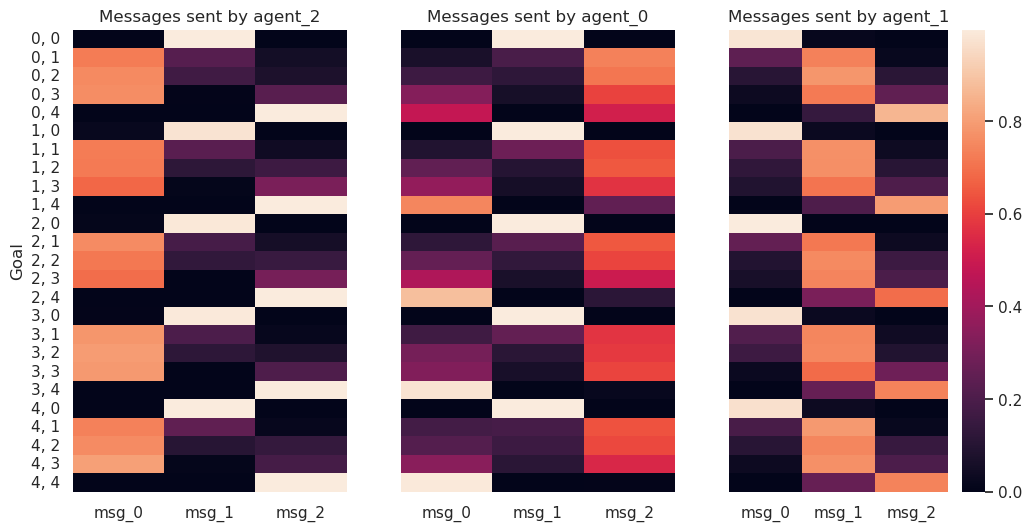

In [ ]:
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(4 * len(agents), 6))
for i, agent in enumerate(agents):
    goal_mean_msgs = df[df.sender == agent].groupby('goal_idx')[msg_cols].mean()
    goal_mean_msgs = goal_mean_msgs.reset_index().set_index('goal_idx')
    sns.heatmap(goal_mean_msgs, ax=axs[i], cbar=i == len(agents) - 1)
    axs[i].set_title(f'Messages sent by {agent}')
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Goal')
        axs[i].set_yticklabels([
            f'{int(x)}, {int(y)}'
            for x in range(world_w)
            for y in range(world_h)
        ])

plt.show()

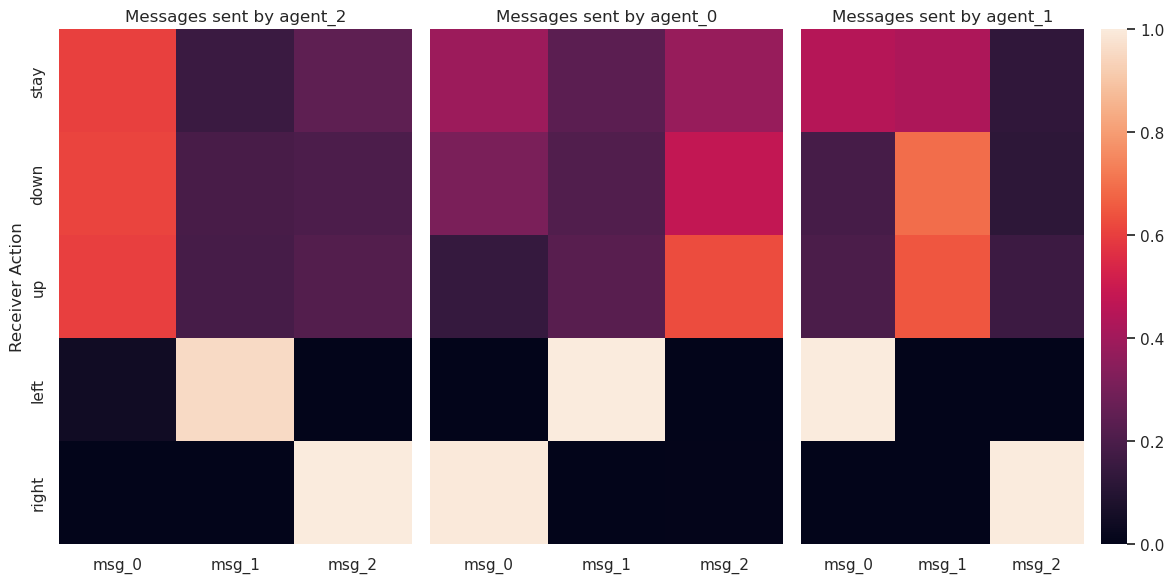

In [ ]:
agents = df['sender'].unique()
_, axs = plt.subplots(1, len(agents), figsize=(4 * len(agents), 6))
for i, agent in enumerate(agents):
    action_mean_msgs = df[df.sender == agent].groupby('receiver_action')[msg_cols].mean()
    action_mean_msgs = action_mean_msgs.reset_index().set_index('receiver_action')
    sns.heatmap(action_mean_msgs, ax=axs[i], cbar=i == len(agents) - 1, vmin=0, vmax=1)
    axs[i].set_title(f'Messages sent by {agent}')
    if i > 0:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
    else:
        axs[i].set_ylabel('Receiver Action')
        axs[i].set_yticklabels(["stay", "down", "up", "left", "right"])

plt.tight_layout()
plt.show()

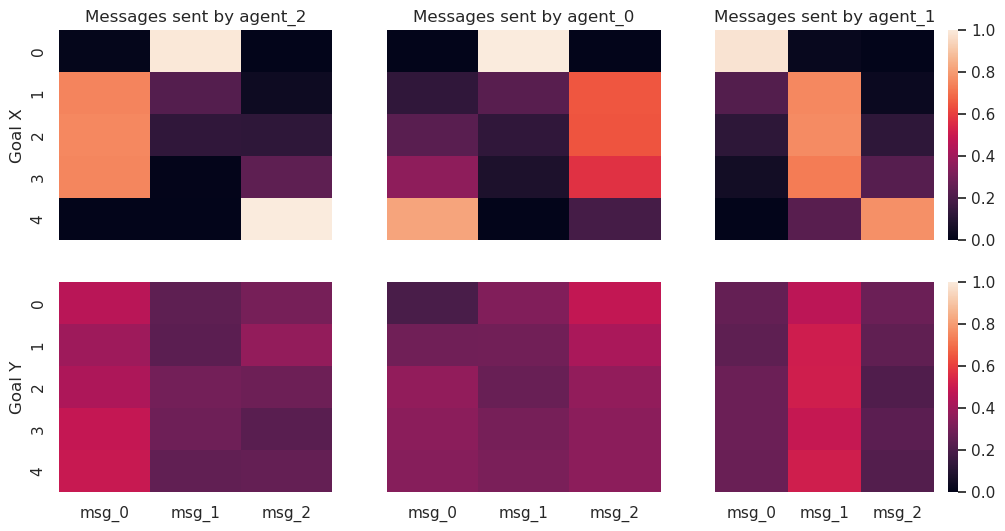

In [ ]:
agents = df['sender'].unique()
_, axs_grid = plt.subplots(2, len(agents), figsize=(4 * len(agents), 6))
for i, agent in enumerate(agents):
    agent_df = df[df.sender == agent]
    
    goal_x_mean_msgs = agent_df.groupby('goal_x')[msg_cols].mean()
    goal_x_mean_msgs = goal_x_mean_msgs.reset_index().set_index('goal_x')
    sns.heatmap(goal_x_mean_msgs, ax=axs_grid[0][i], cbar=i == len(agents) - 1, vmin=0, vmax=1)

    goal_y_mean_msgs = agent_df.groupby('goal_y')[msg_cols].mean()
    goal_y_mean_msgs = goal_y_mean_msgs.reset_index().set_index('goal_y')
    sns.heatmap(goal_y_mean_msgs, ax=axs_grid[1][i], cbar=i == len(agents) - 1, vmin=0, vmax=1)

    axs_grid[0][i].set_title(f'Messages sent by {agent}')
    axs_grid[0][i].set_xticks([])
    if i > 0:
        axs_grid[0][i].set_ylabel('')
        axs_grid[0][i].set_yticks([])
        axs_grid[1][i].set_ylabel('')
        axs_grid[1][i].set_yticks([])
    else:
        axs_grid[0][i].set_ylabel('Goal X')
        # axs_grid[0][i].set_yticklabels(["stay", "down", "up", "left", "right"])
        axs_grid[1][i].set_ylabel('Goal Y')
        # axs_grid[1][i].set_yticklabels(["stay", "down", "up", "left", "right"])

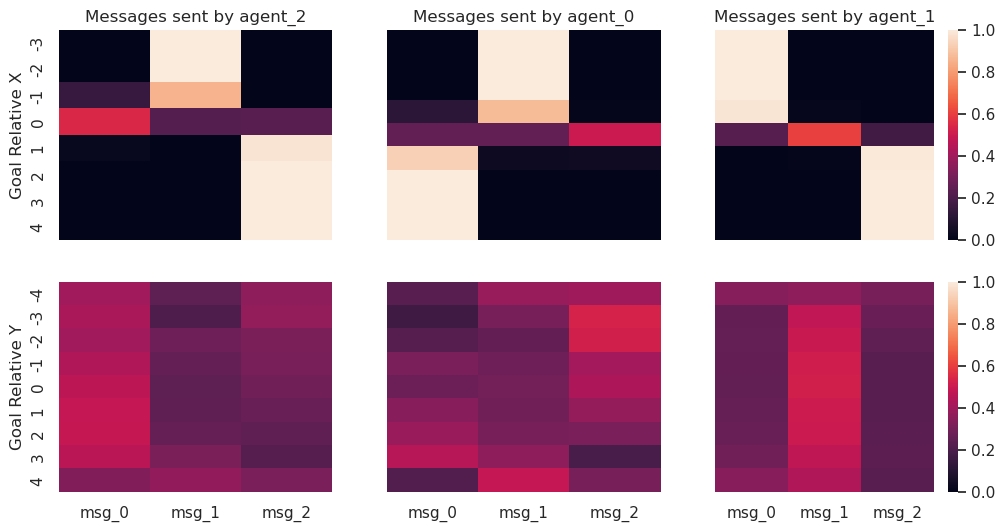

In [ ]:
df['goal_rel_x'] = df['goal_x'] - df['pos_x']
df['goal_rel_y'] = df['goal_y'] - df['pos_y']
agents = df['sender'].unique()
_, axs_grid = plt.subplots(2, len(agents), figsize=(4 * len(agents), 6))
for i, agent in enumerate(agents):
    agent_df = df[df.sender == agent]
    
    goal_x_mean_msgs = agent_df.groupby('goal_rel_x')[msg_cols].mean()
    goal_x_mean_msgs = goal_x_mean_msgs.reset_index().set_index('goal_rel_x')
    sns.heatmap(goal_x_mean_msgs, ax=axs_grid[0][i], cbar=i == len(agents) - 1, vmin=0, vmax=1)

    goal_y_mean_msgs = agent_df.groupby('goal_rel_y')[msg_cols].mean()
    goal_y_mean_msgs = goal_y_mean_msgs.reset_index().set_index('goal_rel_y')
    sns.heatmap(goal_y_mean_msgs, ax=axs_grid[1][i], cbar=i == len(agents) - 1, vmin=0, vmax=1)

    axs_grid[0][i].set_title(f'Messages sent by {agent}')
    axs_grid[0][i].set_xticks([])
    if i > 0:
        axs_grid[0][i].set_ylabel('')
        axs_grid[0][i].set_yticks([])
        axs_grid[1][i].set_ylabel('')
        axs_grid[1][i].set_yticks([])
    else:
        axs_grid[0][i].set_ylabel('Goal Relative X')
        # axs_grid[0][i].set_yticklabels(["stay", "down", "up", "left", "right"])
        axs_grid[1][i].set_ylabel('Goal Relative Y')
        # axs_grid[1][i].set_yticklabels(["stay", "down", "up", "left", "right"])